In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=3e2df5cc999207ba16a72bdefbe822068ca6c5ded22f4c2328bb32f1988e6083
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
import pickle

from node2vec import Node2Vec
import networkx as nx
import pandas as pd
import numpy as np
import json
from itertools import count

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
run_node2vec=True

In [ ]:
# social_graph = nx.read_edgelist('edge_list_testlatest.txt') # This can also be run with the edgelist version of the data
social_graph = nx.read_adjlist('ch3_data/adjacency_list_test.txt')

node_attr = pd.read_csv('ch3_data/node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr.info()
social_graph.number_of_edges(), social_graph.number_of_nodes()

node_attr = node_attr.set_index('hashedid')
attribute_dict = node_attr.to_dict(orient='index')
nx.set_node_attributes(social_graph, attribute_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hashedid       1947 non-null   object
 1   company_type   1947 non-null   object
 2   position_type  1947 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB


In [ ]:
nodes_to_remove = [node for node, data in social_graph.nodes(data=True)
                   if 'company_type' not in data or 'position_type' not in data]
social_graph.remove_nodes_from(nodes_to_remove)

In [ ]:
df = pd.DataFrame(attribute_dict).T
df

,company_type,position_type
058b92d6c47c4f8e29b302b30a1fff4a21ba9d36,tech,engineer
e943ba6d3c0eb8589df32a873ab5772c8f77c68f,finance,executive_or_management
07722a6692fb28485ddaf84979322fb5a78d0926,Unknown,marketing_sales
eb319e0714095bc9f9517317e9040f125b8de8d4,Unknown,marketing_sales
acddbb2edb475d3a5fd127075dc146eb9ba94e0e,misc,misc
...,...,...
d2d878318aaa8825d9e0e43b162ae0b33a9a90ca,misc,misc
3e0a9701ee6796753d601a8d9ba551fec1e9b8d3,nonprofit_ngo,executive_or_management
dbfb54497fe275982736b278a69ac0d6554469d0,education,education
ef0a4531dbc7fd4b16765ea67bbbac66c496f392,tech,misc


In [ ]:
print(f"Length of data: {len(df)}")
print(f"Number of company types: {len(df.company_type.unique())}")
print(f"Number of position types: {len(df.position_type.unique())}")

Length of data: 1947
Number of company types: 11
Number of position types: 9


<Axes: xlabel='company_type'>

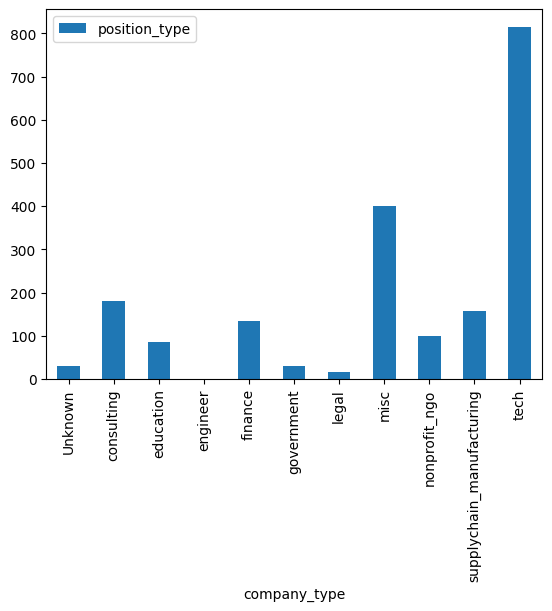

In [ ]:
df.groupby(["company_type"]).count().plot(kind="bar")

<Axes: xlabel='position_type'>

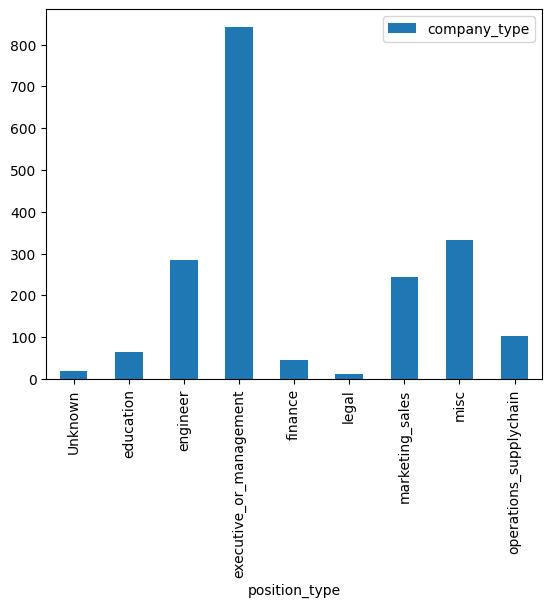

In [ ]:
df.groupby(["position_type"]).count().plot(kind="bar")

Our original graph is disconnected. So, we only deal with its largest connected component.

In [ ]:
sub_graph = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])  #A
sub_graph.number_of_edges(), sub_graph.number_of_nodes()

(12222, 1698)

For visualization purposes, namely, to colorize our nodes, we encode the *company_type* attributes. Later on, we will use this encoding as a color map.

In [ ]:
unique_companies = list(set(nx.get_node_attributes(sub_graph, 'company_type').values()))
company_to_int = {company: i for i, company in enumerate(unique_companies)}

unique_positions = list(set(nx.get_node_attributes(sub_graph, 'position_type').values()))
position_to_int = {position: i for i, position in enumerate(unique_positions)}

company_color_map = [company_to_int[data['company_type']] for node, data in sub_graph.nodes(data=True)]
position_color_map = [position_to_int[data['position_type']] for node, data in sub_graph.nodes(data=True)]
color_maps = {'company':company_color_map, 'position':position_color_map}

with open("color_maps.pkl", 'wb') as f:
    pickle.dump(color_maps, f)

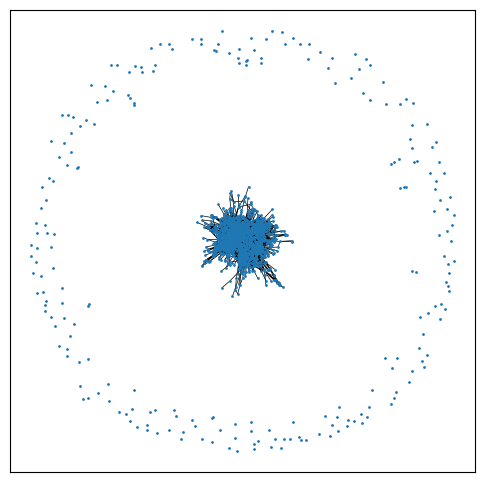

In [ ]:
plt.figure(figsize=(6, 6))
# Draw just the nodes
pos = nx.spring_layout(social_graph, seed=42)
nx.draw_networkx_nodes(social_graph, pos, node_size=1)
nx.draw_networkx_edges(sub_graph, pos, width=0.5)

# Show the plot
plt.show()

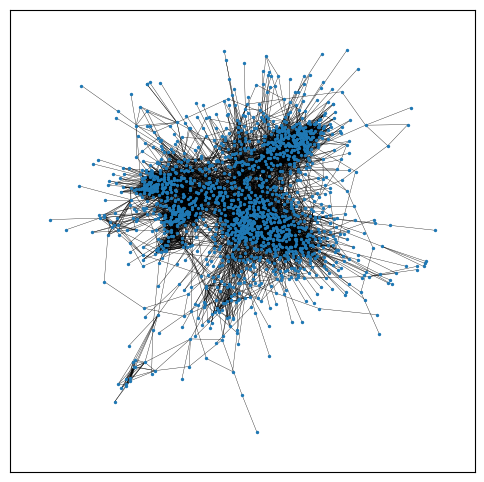

In [ ]:
plt.figure(figsize=(6, 6))
# Draw just the nodes
pos = nx.spring_layout(sub_graph, seed=2023)
nx.draw_networkx_nodes(sub_graph, pos, node_size=2)
nx.draw_networkx_edges(sub_graph, pos, width=0.25)

# Show the plot
plt.show()

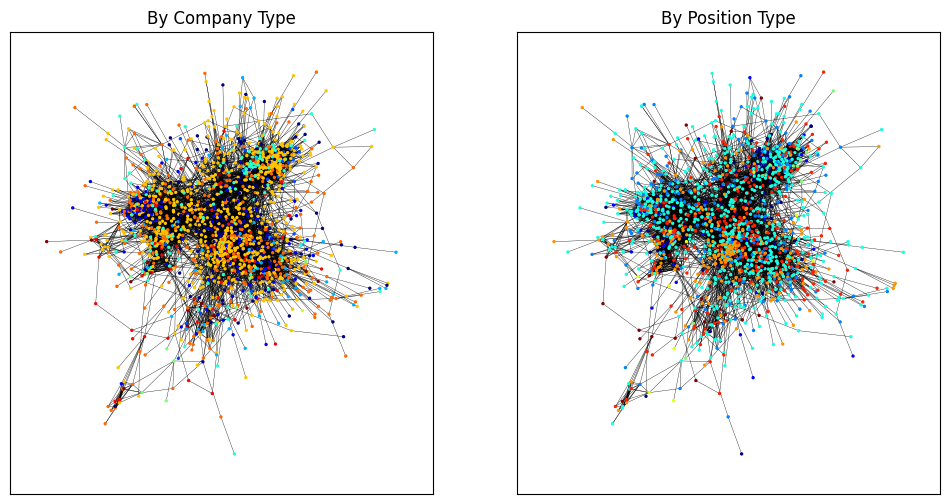

In [ ]:
plt.figure(figsize=(12, 6))

# Plot based on company_type
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(sub_graph, pos, node_color=list(company_color_map), cmap=plt.cm.jet, node_size=2)
nx.draw_networkx_edges(sub_graph, pos, width=0.25)
plt.title('By Company Type')

# Plot based on position_type
plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(sub_graph, pos, node_color=list(position_color_map), cmap=plt.cm.jet,node_size=2)
nx.draw_networkx_edges(sub_graph, pos, width=0.25)
plt.title('By Position Type')

plt.show()

Generate the node embeddings.

* #A  Precompute probabilities and generate walks
* #B Generate embeddings. The batch_words parameter is because much of this function is derived from the Word2Vec algorithm.
* #C Save embedding in a file to disk.


In [ ]:
if run_node2vec:
    node2vec = Node2Vec(sub_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  #A
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  #B
    model.wv.save_word2vec_format('EMBEDDING_FILENAME') #C
    node_ids = model.wv.index_to_key  # List of node IDs
    n2v_embeddings = [model.wv[node_id] for node_id in node_ids]
else:
    with open("EMBEDDING_FILENAME", "r") as social:
        lines = social.readlines()

    embedded_lines = [x.split(' ')[1:] for x in lines[1:]]
    n2v_embeddings = []
    for line in embedded_lines:
        new_line = [float(y) for y in line] #B
        n2v_embeddings.append(new_line)

Computing transition probabilities:   0%|          | 0/1698 [00:00<?, ?it/s]

Read in the embeddings that were saved to disk.


In [ ]:
embeddings = np.array(n2v_embeddings)

In [ ]:
embeddings.shape

(1698, 64)

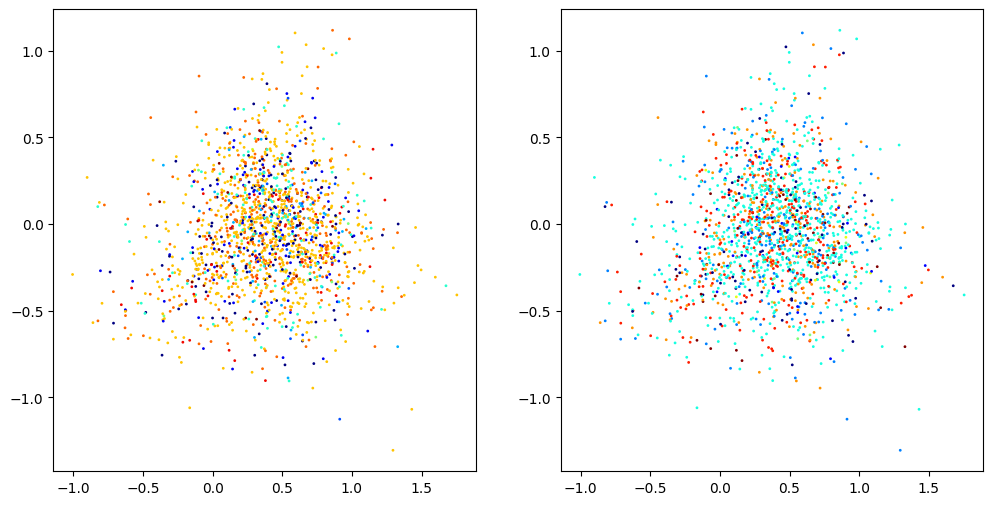

In [ ]:
plt.figure(figsize=(12, 6))

# Select the 0th feature: xs
xs = embeddings[:,0]
# Select the 1st feature: ys
ys = embeddings[:,1]

plt.subplot(1,2,1)
plt.scatter(xs,ys, c=list(company_color_map), s=1, cmap=plt.cm.jet)

plt.subplot(1,2,2)
plt.scatter(xs,ys, c=list(position_color_map), s=1, cmap=plt.cm.jet)
plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=30)
# reduced_embeddings = pca.fit_transform(embeddings)

# # Select the 0th feature: xs
# xs = reduced_embeddings[:,0]
# # Select the 1st feature: ys
# ys = reduced_embeddings[:,1]

# plt.subplot(1,2,1)
# plt.scatter(xs,ys, c=company_color_map, s=1, cmap=plt.cm.jet)

# plt.subplot(1,2,2)
# plt.scatter(xs,ys, c=position_color_map, s=1, cmap=plt.cm.jet)
# plt.show()

In [ ]:
tsne = TSNE(n_components=2,random_state=2023)
gnn_embeddings_tsne = tsne.fit_transform(embeddings)

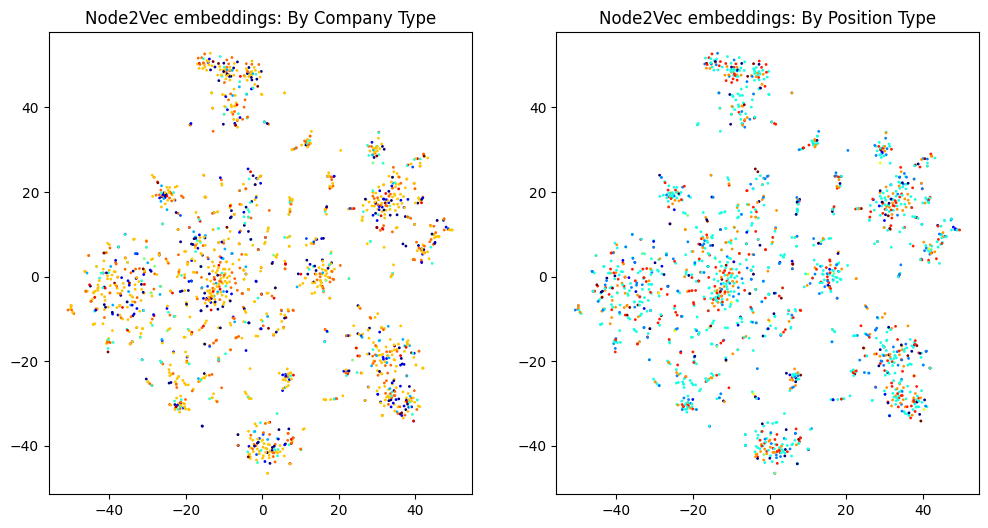

In [ ]:
plt.figure(figsize=(12, 6))

# Select the 0th feature: xs
xs = gnn_embeddings_tsne[:,0]
# Select the 1st feature: ys
ys = gnn_embeddings_tsne[:,1]

plt.subplot(1,2,1)
plt.scatter(xs,ys, c=company_color_map, s=1, cmap=plt.cm.jet)
plt.title('Node2Vec embeddings: By Company Type')

plt.subplot(1,2,2)
plt.scatter(xs,ys, c=position_color_map, s=1, cmap=plt.cm.jet)
plt.title('Node2Vec embeddings: By Position Type')

plt.show()